### Import the necessary packages
<ol>
<li>[mxnet](http://mxnet.io/) for Neural Network creation and training and visualizations </li>
<li>[numpy](http://www.numpy.org/) for data handling</li>
<li>[matplotlib](https://matplotlib.org/) for additional vizualizations</li>
</ol>

In [1]:
import mxnet as mx
import numpy as np
import matplotlib.pyplot as plt

### Now we will download a small dataset to work with.  The inline comments explain the steps in this process

In [2]:
# Download the working dataset - unless it is already on the local machine (mxnet will tell us if we already have the data).
fname=mx.test_utils.download('http://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data')

# Use numpy to create a dataset - suitable for training - from the text file
data = np.genfromtxt(fname, delimiter=',')[:,1:]

# Use numpy again to create labels matching the dataset we created for training
label = np.array([ord(l.split(',')[0])-ord('A') for l in open(fname, 'r')])

INFO:root:letter-recognition.data exists, skipping download


### Lets take a peak at the structure of our data
<ul>
<li>The dataset contains black and white rectangular pixel displays of the 26 letters in the english alphabet</li>
<li>By observing the <i>data.shape</i> property we see <b>(20000,16)</b>  This means there are 20K images with a resolution of 16 pixels
<li>In the cell below we will look at a single data point</li>
</ul>

In [3]:
# What is the shape
print(data.shape)

sample = data[10]
print(sample)


(20000, 16)
[ 3.  9.  5.  7.  4.  8.  7.  3.  8.  5.  6.  8.  2.  8.  6.  7.]


### You may be wondering where the image of the characters are at.
<ul>
<li>What we see above is 16 "primitive numerical attriubtes"</li>
<li>These attributes where "scaled to fit into a range of integer values from 0 through 15</li>
<li>This is a one way process that we cannot reverse.  The 16 digits have essentially become the signature of the character</li>
<li>Here is what the first five data entries look like in the data file</li>
<ol>
    <li>T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8</li>
    <li>I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10</li>
    <li>D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9</li>
    <li>N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8</li>
    <li>G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10</li>
</ol>
</ul>

In [4]:
# Batch_size tells mxnet how many characters to run through the network at once.
batch_size = 32

# Let's earmark 80% of our dataset for training 
ntrain = int(data.shape[0]*0.8)

# We will split the data into training and validation 
train_iter = mx.io.NDArrayIter(data[:ntrain, :], label[:ntrain], batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(data[ntrain:,:], label[ntrain:], batch_size)

### With our data now split into training and validation sets we are ready to build our network
The cell below builds the layers of our MLP (multi-layer-perceptron)

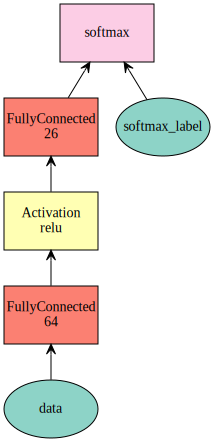

In [5]:
# Declare our netowrk definition
net = mx.sym.Variable('data')

# Add a fully connected layer
net = mx.sym.FullyConnected(net, name='fc1', num_hidden=64)

# Add a rectified linear unit (relu) layer - this defines the output of the node
net = mx.sym.Activation(net, name='relu1', act_type="relu")

# add another fully connected layer
net = mx.sym.FullyConnected(net, name='fc2', num_hidden=26)

# add a softmax layer - this will normalize the output to be between 0 and 1
net = mx.sym.SoftmaxOutput(net, name='softmax')

# let's look at a conceptual view of our network
mx.viz.plot_network(net)

### Introduction to the MXnet Module
Training a Neural Network invloves many steps
<ul>
<li>How to feed input data</li>
<li>Initialize model parameters</li>
<li>Perform forward and backward passes through the network</li>
<li>Update weights based on computed gradients</li>
<li>Model training</li>
</ul>
Managing these steps can be cumbersome.  MXNet can modularize commonly used code in the [module](http://mxnet.io/tutorials/basic/module.html) package

In [6]:
# Contruct a module by specifiying the following parameters
# Symbol = the Network definition - defined above with the "net" variable
# Context = the device (or list of devices) to use for execution
# Data_Names = the list of input data varaible names.
# Label_names = the list of input label variable names.
mod = mx.mod.Module(symbol=net,
                   context=mx.cpu(),
                   data_names=['data'],
                   label_names=['softmax_label'])

In [7]:
# Now that the Module object is created we need to prepare the enviroment by allocating memory (bind)
mod.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)

# Assign and initialize parameters
mod.init_params(initializer=mx.init.Uniform(scale=.1))



### Lets recap what we have done before we actually train our model
Thus far we have:
<ul>
<li>Acquired and loaded training data</li>
<li>Split the data into training and validation data sets</li>
<li>Defined our network</li>
<li>Created a Module object to assist with the actual training of the network</li>
</ul>

Epoch 0, Training ('accuracy', 0.48456250000000001)
Epoch 1, Training ('accuracy', 0.66731249999999998)
Epoch 2, Training ('accuracy', 0.70050000000000001)
Epoch 3, Training ('accuracy', 0.71418749999999998)


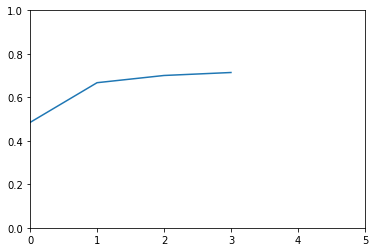

In [8]:
# Initialize the optimizer (defaults to "sgd") MXNet supports the following optimizers:
# NAG
# RMSProp
# Adam
# AdaGrad
# AdaDelta
# DCASGD
# SGLD
mod.init_optimizer(optimizer='AdaGrad', optimizer_params=(('learning_rate', 0.1), ))

# Create an evaluation metric based on the metric type
# We will use accuracy = 'acc'
metric = mx.metric.create('acc')

va = []
# The number of epochs is simply telling MXnet how many time to run our data through the network 
for epoch in range(4):
    
    # reset the cursor of our training iterator to the starting point
    train_iter.reset()
    
    # clear previous epoch metric information
    metric.reset()
    
    for batch in train_iter:
        mod.forward(batch, is_train=True)
        mod.update_metric(metric, batch.label)
        mod.backward()
        mod.update()
    va.append(metric.get()[1])
    print('Epoch %d, Training %s' % (epoch, metric.get()))

# Plot the graph of the networks accuracy        
plt.plot(va)
plt.axis([0,5, 0,1.0])
plt.show()

![title](img/stophere.jpg)

When the instructor indicates it is time to continue - click [here](AML-200.ipynb) to go to the next lab